In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [204]:
df = pd.read_csv("data/Hobart_airport_daily_precip.csv")
dates = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [205]:
# Clean up data frame
df = df.drop('Product code', 1)
df = df.drop('Bureau of Meteorology station number', 1)
df = df.rename(columns={'Rainfall amount (millimetres)': 'PPT', 'Period over which rainfall was measured (days)': 'period'})

In [206]:
# Make an Australian year, drop first and last six months.
dates = dates + pd.DateOffset(months=-6)
df['dates'] = dates
df = df.set_index('dates')
df.Year = df.index.year
df.Month = df.index.month
first_year = df.index.year[0]
last_year = df.index.year[-1]
df = df[df.Year > first_year]
df = df[df.Year < last_year]

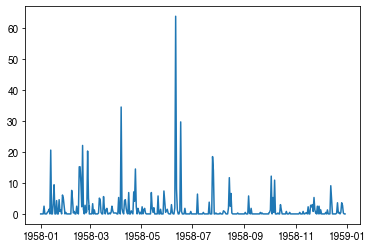

In [207]:
# Plot "new" 1958, this should shift PPT to "UK" summer
plt.plot(df[df.Year==1958].PPT)

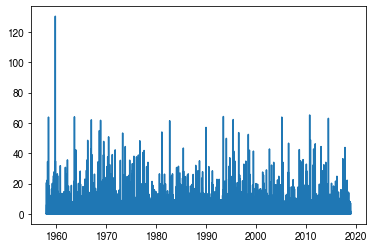

In [208]:
# Plot all years
plt.plot(df.PPT)

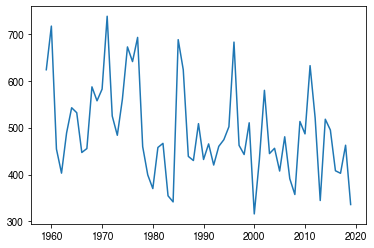

In [209]:
# Plot MAP
dfa = df.resample('A').agg("sum")
plt.plot(dfa.PPT)

In [210]:
print("MAP (mm yr-1):", dfa.PPT.mean())

MAP (mm yr-1): 492.8950819672132


In [211]:
# Calculate consecutive dry days
threshold = 0.2 # mm 
consecutive_dry = [ 1 if i <= threshold else 0 for i in df.PPT ]

count = 0
dry_days = []
for i in range(len(df)-1):

    if consecutive_dry[i] == 1:
        count += 1
        if consecutive_dry[i+1] == 0:
            dry_days.append(count)
        else:
            dry_days.append(0)
    else:
        count = 0
        dry_days.append(0)

# As we ended the loop one element early
if consecutive_dry[-1] == 1:
    dry_days.append(1)

# if day before last one was dry, increase the count and store on final day
if dry_days[-2] > 0:
    dry_days[-1] = dry_days[-2] + 1
    dry_days[-2] = 0

In [229]:
df_spells = pd.DataFrame(dry_days, columns=['dry'])
df_spells['dates'] = df.index
df_spells = df_spells.set_index('dates')
df_spells['dry'] = df_spells['dry'].mask(df_spells['dry'] == 0)

In [230]:
df_spells.dry

dates
1958-01-01    NaN
1958-01-02    NaN
1958-01-03    NaN
1958-01-04    4.0
1958-01-05    NaN
             ... 
2018-12-26    NaN
2018-12-27    NaN
2018-12-28    NaN
2018-12-29    NaN
2018-12-30    1.0
Name: dry, Length: 22280, dtype: float64

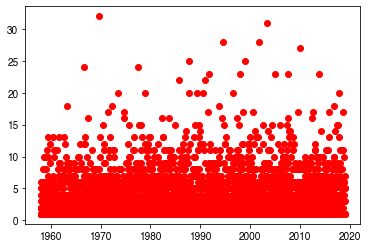

In [231]:
plt.plot(df.index, df_spells.dry, "ro")

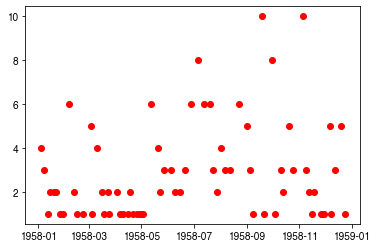

In [232]:
plt.plot(df.index[0:365], df_spells.dry[0:365], "ro")

In [233]:
# check logic...
x = df_spells.dry[0:365]
x = x[~np.isnan(x)]
x.max(), x.mean(), x.median()

(10.0, 2.8732394366197185, 2.0)

In [234]:
df_spells_a = df_spells.resample('A').agg(["max", "mean", "median"])
df_spells_a.iloc[0]

dry  max       10.000000
     mean       2.873239
     median     2.000000
Name: 1958-12-31 00:00:00, dtype: float64

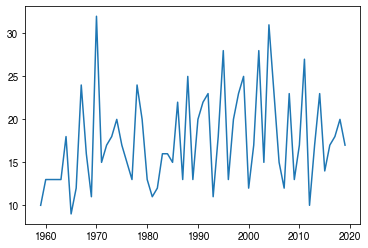

In [235]:
plt.plot(df_spells_a.dry["max"])

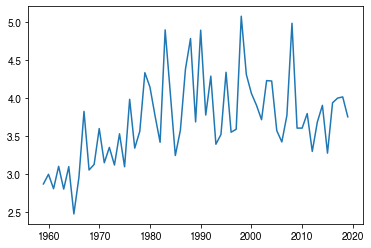

In [236]:
plt.plot(df_spells_a.dry["mean"])

In [237]:
print(df_spells_a.dry["max"].mean(), df_spells_a.dry["mean"].mean(), df_spells_a.dry["median"].mean())

17.557377049180328 3.7003956207171007 2.737704918032787


15.491803278688524 3.928833453097604


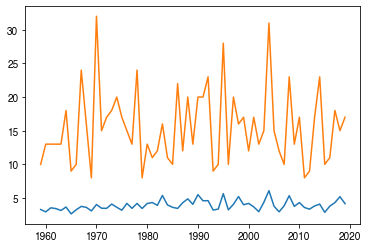

In [227]:
# Do same thing for spring/summer - MAX
df_spells_grw = df_spells[(df_spells.index.month >= 4) & (df_spells.index.month < 10)]
df_spells_grw_a = df_spells_grw.resample('A').agg(["max","mean"])
plt.plot(df_spells_grw_a.dry["mean"])
plt.plot(df_spells_grw_a.dry["max"])
print(df_spells_grw_a.dry["max"].mean(), df_spells_grw_a.dry["mean"].mean())

In [254]:
# Get 5 driest spells + you need to mentally add 6 to get the correct month
df_spells_grw.sort_values(by="dry").iloc[-5:]

,dry,month
dates,,
1966-08-22,24.0,8
1977-07-26,24.0,7
1994-06-28,28.0,6
2003-06-03,31.0,6
1969-08-15,32.0,8


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


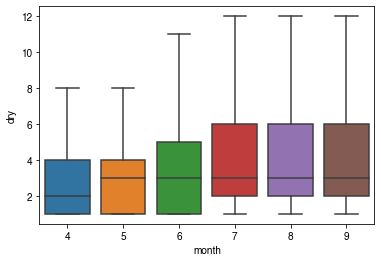

,dry,month
dates,,
1958-04-03,2.0,4
1958-04-06,1.0,4
1958-04-10,1.0,4
1958-04-15,1.0,4
1958-04-18,2.0,4
...,...,...
2018-09-11,1.0,9
2018-09-19,6.0,9
2018-09-21,1.0,9


In [228]:
df_spells_grw = df_spells[(df_spells.index.month >= 4) & (df_spells.index.month < 10)]
df_spells_grw["month"] = df_spells_grw.index.month
df_spells_grw = df_spells_grw[~np.isnan(df_spells_grw.dry)]

import seaborn as sns
sns.boxplot(data=df_spells_grw, x='month', y="dry", showfliers=False) # ignoring outliers for visual purposes
plt.show()
df_spells_grw

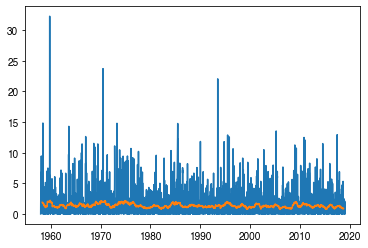

In [199]:
# Look at rolling window as proxy for any trend / change in freq.

# min_periods to account for missing data
plt.plot(df["PPT"].rolling(window=7, center=True, min_periods=3).mean())
plt.plot(df["PPT"].rolling(window=365, center=True, min_periods=300).mean())

In [200]:
# Check for randomness of data - annual
autocorrelation_plot(df.PPT.resample("A").agg("sum")) 

NameError: name 'autocorrelation_plot' is not defined

In [201]:
# Look at the reln between spring PPT and summer PPT
spring = df[(df.index.month >= 4) & (df_spells.index.month < 7)].PPT
spring = spring.resample("A").agg("sum")

summer = df[(df.index.month >= 7) & (df_spells.index.month < 10)].PPT
summer = summer.resample("A").agg("sum")

0.09506492662893944


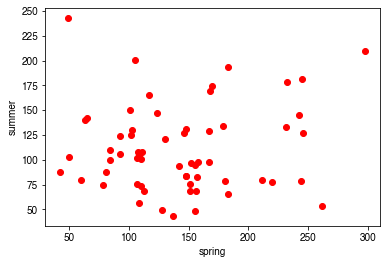

In [202]:
plt.plot(spring, summer, "ro")
plt.xlabel("spring")
plt.ylabel("summer")
print(np.corrcoef(spring, summer)[0, 1])
